In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


### Install packages

In [ ]:
!pip install --upgrade diffusers[torch] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers accelerate scipy safetensors -q

In [ ]:
!pip install peft transformers accelerate bitsandbytes -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.0 MB/s eta 0:00:00


### Import library

In [ ]:
import gc
import time
import requests
from PIL import Image

import torch

### Basic setting

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
precomputed_prompt = """
목표:
주어진 일기 내용을 분석하여 핵심 장면을 추출하고, 스타일 정보에 맞게 Stable Diffusion 프롬프트로 변환하라.
사적인 정보(이름, 구체적인 개인 경험)는 제거하되, 감정과 분위기를 유지하도록 한다.
    77자 이내로 불필요한 디테일을 줄이고 간결하면서도 생생한 묘사를 제공하라.

입력 형식:
- 스타일 정보: 이미지의 스타일 및 분위기 (예: realistic, anime, cinematic lighting, oil painting, 3D render, fantasy 등)
- 일기: 하루의 경험, 감정, 분위기가 담긴 글

출력 형식 (Stable Diffusion Prompt):
- 핵심 장면 요약: 일기에서 장면을 추출하여 생동감 있는 이미지 설명 생성
- 스타일 적용: 스타일 정보에 맞게 이미지의 분위기 및 표현 방식을 결정
- 감정 강조: 감정, 조명, 분위기, 색감을 포함하여 몰입감을 높임
"""

# precomputed_prompt = """
# 목표:
# 주어진 일기 내용을 분석하여 핵심 장면을 추출하고, 스타일 정보에 맞게 Stable Diffusion 프롬프트로 변환하라.
# 개인 정보를 제거하되, 감정과 분위기는 그대로 유지하여 생생한 시각적 묘사를 제공하라.
# 길이는 77자 이내로 유지하며, 장면의 핵심 요소를 강조하여 직관적인 이미지 생성이 가능하도록 한다.

# 입력 형식:
# - **스타일 정보**: realistic, anime, cinematic lighting, oil painting, 3D render, fantasy 등
# - **일기 내용**: 하루의 경험, 감정, 분위기 등이 담긴 글

# 출력 형식 (Stable Diffusion Prompt):
# - **핵심 장면 요약**: 일기에서 중요한 장면을 압축하여 직관적인 이미지 설명 생성
# - **스타일 적용**: 스타일 정보에 맞춰 색감, 조명, 질감, 화풍을 반영
# - **감정 강조**: (빛과 그림자:1.3), (색감:1.2), (공간감:1.3), (감정 표현:1.5) 등을 활용하여 몰입감 강화
# - **구도 및 분위기 가이드**: 초점, 원근법, 카메라 시점 (low-angle, bird's-eye view, cinematic framing 등) 반영
# - **특정 아티스트 스타일 적용** (선택적): ((Studio Ghibli:1.4)), ((Greg Rutkowski:1.3)), ((ArtStation Trending:1.2))

# 예시 출력:
# - "A cozy café on a rainy evening, warm candlelight reflecting on the window, a steaming cup of coffee, blurred neon lights outside. (soft lighting:1.3), (cinematic atmosphere:1.4), (realistic photography:1.2)."
# """


In [ ]:
example_diary = [
    """오늘은 비가 내렸다. 창밖을 보며 따뜻한 차를 마시는데, 마음이 차분해졌다.
    빗소리를 들으며 책을 읽으니 시간 가는 줄도 몰랐다.
    문득, 어린 시절 장화 신고 빗속에서 뛰놀던 기억이 떠올랐다.
    그때처럼 자유롭게 살아가고 싶다는 생각이 든 하루였다.""",

    """친구들과 오랜만에 만났다. 맛있는 파스타를 먹으며 수다를 떨었는데, 너무 즐거웠다.
    다들 바빠서 자주 만나지 못하지만, 이렇게 모이면 어제 본 것처럼 편안하다.
    좋은 사람들과 함께하는 시간은 언제나 소중하다.""",

    """오늘은 조금 힘든 하루였다. 회사에서 실수를 해서 혼이 났다.
    내가 부족한 걸까? 자책했지만, 실수를 통해 배우는 것도 중요하다고 생각하려고 한다.
    내일은 더 나아질 거라고 믿으며 스스로를 다독였다.""",

    """주말이라서 근교로 여행을 다녀왔다. 공기가 맑고, 바람이 상쾌했다.
    한적한 시골길을 걷다 보니 마음이 평온해졌다.
    자연 속에 있으면 모든 고민이 작아지는 기분이다.
    다음에는 캠핑도 해보고 싶다.""",

    """요즘 밤하늘이 너무 예쁘다. 오늘도 산책하면서 별을 봤다.
    반짝이는 별빛을 보고 있으면, 머릿속이 맑아지는 느낌이 든다.
    어릴 때는 별을 보며 우주에 대해 상상하곤 했는데,
    그런 순수한 감성을 다시 찾고 싶다는 생각이 들었다.""",
]

In [ ]:
style_info = [
    "Realistic",  # 사실적인 스타일
    "Photorealistic",  # 사진과 같은 품질
    "Anime",  # 애니메이션 스타일
    "Pixel Art",  # 픽셀 아트 스타일
    "Cyberpunk",  # 미래 지향적인 사이버펑크 스타일
    "Steampunk",  # 산업혁명 기반 스팀펑크 스타일
    "Fantasy",  # 판타지 일러스트 스타일
    "Sci-Fi",  # 공상과학 스타일
    "Watercolor",  # 수채화 스타일
    "Oil Painting",  # 유화 스타일
    "Sketch",  # 연필 스케치 스타일
    "Cartoon",  # 만화 스타일
    "Ukiyo-e",  # 일본 전통 우키요에 스타일
    "Gothic",  # 고딕풍 스타일
    "Surrealism",  # 초현실주의 스타일
    "Art Nouveau",  # 아르누보 스타일
    "Art Deco",  # 아르데코 스타일
    "Low Poly",  # 저폴리곤 스타일
    "Isometric",  # 등각 투영 스타일
    "Minimalist",  # 미니멀리즘 스타일
    "Vaporwave",  # 복고풍 베이퍼웨이브 스타일
    "Neon Noir",  # 어두운 분위기의 네온 스타일
    "3D Render",  # 3D 렌더링 스타일
]

### Ko-LLM

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer


In [ ]:
# 모델 및 토크나이저 로드
model_name = "yanolja/EEVE-Korean-2.8B-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=device)

# Prompt Caching
# 프롬프트의 고정된 부분을 미리 토큰화하여 저장 → 불필요한 토큰화 작업을 줄임
cached_prompt_tokens = tokenizer(precomputed_prompt, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def generate_stable_diffusion_prompt(style_info, diary_text, is_debug=False):
    """
    사용자 입력을 LLM에 넣어 Stable Diffusion 프롬프트 생성
    """
    start_time = time.time()

    dynamic_input = f"\n\n스타일 정보: {style_info}\n일기:\n{diary_text}\n\nStable Diffusion Prompt:"

    if is_debug:
        print("\n🔹 LLM 입력 텍스트:\n", dynamic_input)

    dynamic_tokens = tokenizer(dynamic_input, return_tensors="pt", truncation=True, max_length=512)
    inputs = {key: torch.cat([cached_prompt_tokens[key], dynamic_tokens[key]], dim=1).to(model.device) for key in cached_prompt_tokens}

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=77, temperature=0.7, do_sample=True, top_k=50)

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_prompt = generated_text.split("Stable Diffusion Prompt:")[-1].strip()

    tokenized_prompt = tokenizer.encode(generated_prompt, add_special_tokens=False)
    if len(tokenized_prompt) > 77:
        generated_prompt = tokenizer.decode(tokenized_prompt[:77], skip_special_tokens=True)

    elapsed_time = time.time() - start_time

    if is_debug:
        print("\n⏳ 걸린 시간: {:.2f}초".format(elapsed_time))

    return generated_prompt

In [ ]:
stable_diffusion_prompt = generate_stable_diffusion_prompt(style_info[9], example_diary[0], is_debug=True)

print("🔹 Stable Diffusion Prompt:")
print(stable_diffusion_prompt)

Setting `pad_token_id` to `eos_token_id`:58943 for open-end generation.



🔹 LLM 입력 텍스트:
 

스타일 정보: Oil Painting
일기:
오늘은 비가 내렸다. 창밖을 보며 따뜻한 차를 마시는데, 마음이 차분해졌다. 
    빗소리를 들으며 책을 읽으니 시간 가는 줄도 몰랐다. 
    문득, 어린 시절 장화 신고 빗속에서 뛰놀던 기억이 떠올랐다. 
    그때처럼 자유롭게 살아가고 싶다는 생각이 든 하루였다.

Stable Diffusion Prompt:

⏳ 걸린 시간: 40.83초
🔹 Stable Diffusion Prompt:
비 내리는 아침, 창밖을 보며 따뜻한 차를 마시는데, 마음이 차분해졌다. 빗소리를 들으며 책을 읽으니 시간 가는 줄도 몰랐다. 문득, 어린 시절 장화 신고 빗속에서 뛰놀던 기억이 떠올랐다. 그 때의 즐거움, 순수함, 그 시절의 풍경이 떠오른다


### Diffusers

In [ ]:
from diffusers import DiffusionPipeline, StableDiffusionPipeline

In [ ]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5" # "stabilityai/stable-diffusion-2-1"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

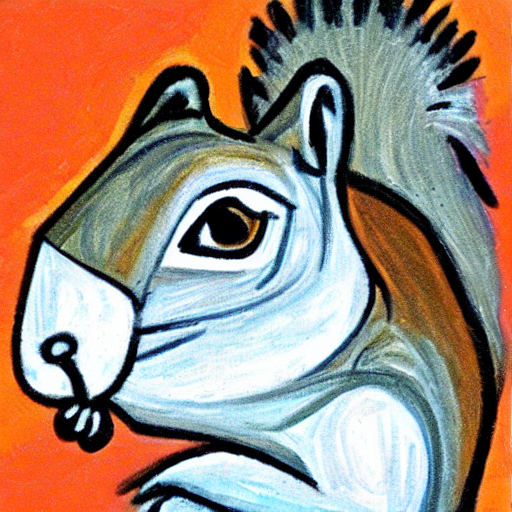

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline.to(device)
pipeline("An image of a squirrel in Picasso style").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

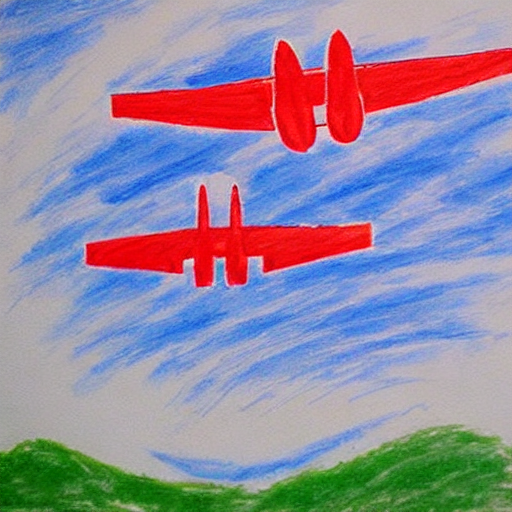

In [ ]:
pipeline("Draw an Airplane in the sky to abstract painting").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

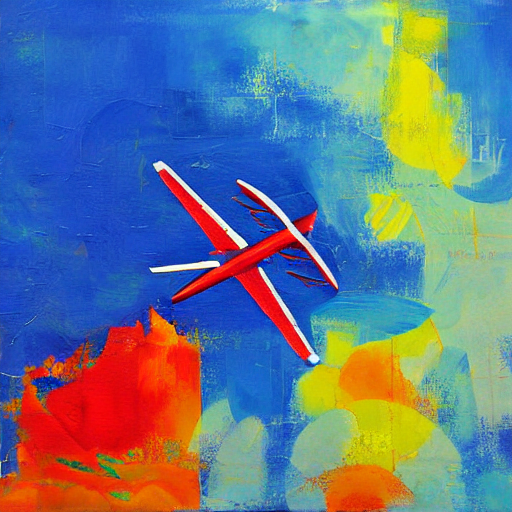

In [ ]:
pipeline("Airplane, blue sky, abstract painting").images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

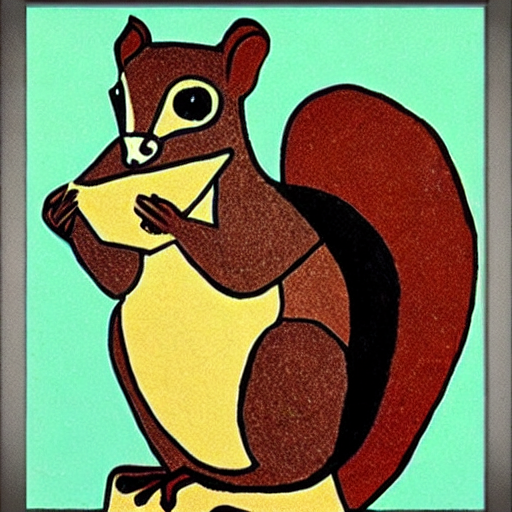

In [ ]:
cpu_pipeline = DiffusionPipeline.from_pretrained(model_id)
cpu_pipeline.to('cpu')
cpu_pipeline("An image of a squirrel in Picasso style").images[0]

In [ ]:
# tiny distillation SD model
distill_pipeline = DiffusionPipeline.from_pretrained("segmind/tiny-sd", torch_dtype=torch.float16)
distill_pipeline.to(device)

image = pipeline("An image of a squirrel in Picasso style").images[0]
# image.save("distillation_model_output.png")

model_index.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


### Ko-SD

In [ ]:
# !git clone https://github.com/KyujinHan/KO-stable-diffusion-anything.git

Cloning into 'KO-stable-diffusion-anything'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 104 (delta 0), reused 0 (delta 0), pack-reused 101 (from 1)
Receiving objects: 100% (104/104), 4.55 MiB | 38.16 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [ ]:
# Anything model
model_id = "kyujinpy/KO-stable-diffusion-anything"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/870k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--kyujinpy--KO-stable-diffusion-anything/snapshots/9fcda35896d022cd9df56957bc94c6d0534d91b4/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--kyujinpy--KO-stable-diffusion-anything/snapshots/9fcda35896d022cd9df56957bc94c6d0534d91b4/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--kyujinpy--KO-stable-diffusion-anything/snapshots/9fcda35896d022cd9df56957bc94c6d0534d91b4/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingfa

In [ ]:
prompt = "유화, 푸른 들판, 남자 아이, 강아지"
image = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Disney model
model_id = "kyujinpy/korean-stable-diffusion-disney"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/870k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--kyujinpy--korean-stable-diffusion-disney/snapshots/75ad4cc812e01ab7cbae61fbf5dd2bd3674e6a3c/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--kyujinpy--korean-stable-diffusion-disney/snapshots/75ad4cc812e01ab7cbae61fbf5dd2bd3674e6a3c/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--kyujinpy--korean-stable-diffusion-disney/snapshots/75ad4cc812e01ab7cbae61fbf5dd2bd3674e6a3c/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--kyujinpy--korean-stable-diffusion-disney/snapshots/75ad4cc812e01ab7cbae61fbf5dd2bd3674e6a3c/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
prompt = "황금빛 머리카락의 마법 공주, 모던한 디즈니 스타일"
image = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]